# HEDIS Rate Evaluation in Outcomes Studies
D.M. Burt, 2022

<code>keywords: HEDIS, outcomes, study, Bayesian, Beta, Bernoulli</code>

We had some questions recently about comparing provider groups' HEDIS rates, and how meaningful a rate is when the number of members in each group is relatively small.  There's some notion that even if a provider has a 100% compliance rate, it isn't quite the same on a set of three members as it would be on a set of fifty members.  Perhaps it's more impressive to have thirty members in compliance than three in compliance, or maybe it's more _indicative_ that what they're doing is working.  

In this module, we'll explore that idea a bit and show how to do some between-groups comparisons of HEDIS rates.  



In [3]:
import numpy as np
from scipy.stats import bernoulli
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from tqdm import tqdm

# Will also need to install graphviz
# linux: sudo apt-get install graphviz

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

from IPython import display
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def set_style():
    font = {'family' : 'Liberation Sans',
            #'size'   : 16
           }
    math_fontfamily = {'family' : 'Liberation Sans',
                      }
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    
set_style() 


rcParams["mathtext.fontset"] = 'custom'
rcParams["mathtext.rm"] = 'Liberation Sans'
rcParams["mathtext.it"] = 'Liberation Sans'
rcParams["mathtext.sf"] = 'Liberation Sans'
rcParams['font.cursive'] = 'Liberation Sans'

%config InlineBackend.figure_format = 'svg'   # saves image formats in vector graphics (sharper, scalable graphics)

<br><br>
## The data

We model the member-level data as a <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution" target="_blank">Bernoulli distribution</a>, which draws individual data points as a <code>1</code> or <code>0</code>, like a coin flip.  Except, rather than flips of a fair (50/50 probability) coin, it's compliance/non-compliance under a particular HEDIS measure, with some given probability of compliance.

We're going to create two groups for our data, unimaginatively named __Group A__ and __Group B__, and each of these two groups is associated with a physician practice.  What we want to do is see how different compliance is between Group A and Group B.  The compliance rates for the HEDIS measure of interest are as follows:

| Group | N Mbrs | Compliance|
|---|---|---|
| A | 100| 70%|
| B | 100| 40%|
|Difference|   | 30%|

On the face of it, this is simple: if we already know the actual compliance rates, 1) why are we "modeling" data, and 2) we already know the answer: 30%.  These are solid questions, and the answers get to why we use statistical methods at all.  


### Why are we making a "model" of something we already have in reality?

The first question: why are we modeling data, when we already know the compliance rate?  Presumably, we also know the number of members in each group--and in our example, we do (100).  So why not make a "Group A" dataset with 30 zeros and 70 ones and a "Group B" dataset with 60 zeros and 40 ones?  That's real.  Why make something fake to replace it?  In future steps, we're going to do just that, but here at first we want to understand that real data is at least a little messy and to some degree--random.  Like with (fair) coin flips, you know how many heads you'll _probably_ flip in the long run, but you don't have any idea if the next flip will be heads.  With 1,000 flips, you'll probably have somewhere near 500 heads; with 100 flips, you'll probably have somewhere near 50 heads, and with 10 flips...

In [4]:
flips_1000 = bernoulli.rvs(p=0.5, size=1000)
flips_100  = bernoulli.rvs(p=0.5, size=100)
flips_10   = bernoulli.rvs(p=0.5, size=10)

print('Heads in 1000 flips: {} ({:.1%})'.format(np.sum(flips_1000), np.mean(flips_1000)))
print('Heads in 100 flips:  {} ({:.1%})'.format(np.sum(flips_100), np.mean(flips_100)))
print('Heads in 10 flips:   {} ({:.1%})'.format(np.sum(flips_10), np.mean(flips_10)))

Heads in 1000 flips: 489 (48.9%)
Heads in 100 flips:  35 (35.0%)
Heads in 10 flips:   7 (70.0%)


In [5]:
# This is what the flips_10 dataset looks like
flips_10

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1])

Run that code sample several times.  The percentage of heads in 1000 flips won't change much, but the percentage of heads in 10 flips will.

The idea is this: how much do we _trust_ that the 70% HEDIS rate is stable?  If Group A only had 10 members in a given month with a 70% compliance rate, what will the next month look like?  Some HEDIS rates only go up throughout the year, but some vary.  A single compliant member who loses eligibility will drop that rate to 67% (six compliant members out of nine remaining), assuming any of the remaining members don't become compliant.  Besides that, there are truly random things that impact individual members (like eligibility, access to their "Group A" provider, and ability to take time off work to go see that provider).  

To take this idea to an extreme: imagine that there's also a "Group C" provider with only one member.  That provider's compliance rate can only be 0% or 100%--there's no real in-between.  If the provider got a 100% compliance rate, that's good!  But it also isn't as impressive as a provider with a 100% compliance rate on 100 members: not just because 100 compliant members makes more of an impact in our overall HEDIS rates, but because there's some intuitive sense that 1 member becoming compliant (or remaining non-compliant) is influenced by chance.  That is, one member becoming compliant is influenced a lot more by chance than 100 members becoming compliant (think about 1 heads out of 1 flip versus 100 heads out of 100 flips!).  A provider with a 100% compliance on 100 members must be doing something right--again, there's an intuition we have, based on our life experience, that chance can't play nearly as much of a role on the outcomes of 100 members as it can on the outcome of one member.  

### Don't we already know the answer?  It's 30%...

In our actual data, where Group A compliance is 70% and Group B compliance is 40%, we know the difference is 30%.  What's the purpose of statistics in that?  Here's the secret: statistics doesn't give you the 30% difference.  That's just primary school arithmetic--you don't need statistics to get that answer, and that answer is real.  However, since we model how _likely_ our compliance rates are in the two groups and the 70% and 40% rates become _fuzzier_, the difference becomes fuzzier, too.  

We can again flip some coins.  One coin is fair (50% chance of heads), and one is not (70% chance of heads).  Are we likely to figure out that the second coin isn't fair after just ten flips?  If you ran the code example above several times, you probably saw that the percentage of heads differed quite a bit between runs.  And "probably" is the operative word in statistics.  Let's do that ten-coin-flips experiment a bunch of times to see how "probably" that range is:


In [6]:
# We'll make a numpy array to store each 10-flip result.
fair_flips = np.zeros(1000)

# Then we'll do those 10 flips a thousand times, recording the percentage of heads in each run
for i in range(1000):
    fair_flips_10 = bernoulli.rvs(p=0.5, size=10)
    fair_flips[i] = np.sum(fair_flips_10)

We will now graph the distribution of those flips.  The _seaborn_ library in Python has several plotting functions for histograms, namely <code>histplot</code>, <code>distplot</code>, and <code>displot</code> (note the lack of a "t" in that last one), with _displot_ being the current preferred (the seaborn team is deprecating _histplot_ and _distplot_, preferring to put the functionality of both of these into the _displot_ function).  While these functions do a great job binning and plotting continuous-valued data, they don't do as well with discrete-valued data, especially if there are only a few unique values.  These functions sometimes leave some bins out and have unexpected x-axis labels (for example, making a spot on the axis for 0.5, when the data only have values of zero or one).  

To address that, we will make our own quick histogram plot function for this example using seaborn's <code>bar</code> function and adding our own aesthetics.

In [7]:
def plot_hist(data, title='', title_size=12, label='count percent'):

    if str(type(data))!='<class \'list\'>':
        data = [data]
        
    if str(type(title))!='<class \'list\'>':
        title = [title]
        
    # If there are fewer title strings than data arrays, then make the title list as long as the data list (with empties)
    if len(data) > len(title):
        title.append('' * len(title) - len(data))
               
    for n,(d,t) in enumerate(zip(data, title)):        
        labels, counts = np.unique(d, return_counts=True)
        percents = counts/len(d)

        plt.subplot(1,len(data),n+1)
        g = plt.bar(labels, counts, align='center', color='#66bbdd')
        bars = g.patches
        
        for bar, count, percent in zip(bars, counts, percents):
            height = bar.get_height()
            if label=='count':
                plt.annotate(text='{}'.format(count), 
                         xy=((bar.get_x() + bar.get_width()/2), height+1), 
                         ha='center'
                        )
            if label=='percent':
                plt.annotate(text='{:.1%}'.format(percent), 
                         xy=((bar.get_x() + bar.get_width()/2), height+1), 
                         ha='center'
                        )        
            if label=='count percent':
                plt.annotate(text='{} ({:.1%})'.format(count, percent), 
                         xy=((bar.get_x() + bar.get_width()/2), height+1), 
                         ha='center'
                        )
            else: continue  # no bar labels

        plt.gca().set_xticks(labels)
        plt.title(t, size=title_size)
        
        sns.despine()


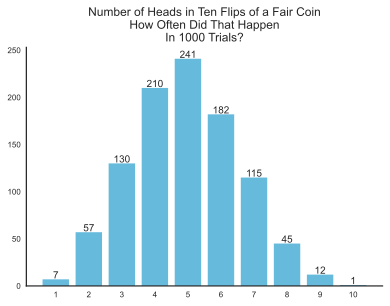

In [8]:
plot_hist(fair_flips, 
          title='Number of Heads in Ten Flips of a Fair Coin\nHow Often Did That Happen\nIn 1000 Trials?',
          label='count'
         );

It is not inconceivable that you might have run that code and seen 10 heads in 10 flips--or no heads in 10 flips.  It is very unlikely, though.

That said, does an unfair coin that flips heads 70% of the time look much different?

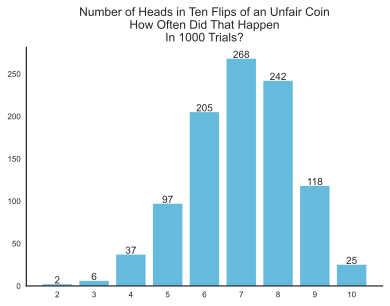

In [9]:
# We'll make a numpy array to store each 10-flip result.
unfair_flips = np.zeros(1000)

# Then we'll do those 10 flips a thousand times, recording the percentage of heads in each run
for i in range(1000):
    unfair_flips_10 = bernoulli.rvs(p=0.7, size=10)   # <-- note that the probability is 60% now
    unfair_flips[i] = np.sum(unfair_flips_10)
    
plot_hist(unfair_flips, 
          title='Number of Heads in Ten Flips of an Unfair Coin\nHow Often Did That Happen\nIn 1000 Trials?',
          label='count'
         );

This is pretty different in some ways--in other ways, it's not.

If we flipped a coin--not knowing if it was the fair or unfair coin--and we got 1 head in ten flips, it's probably not the unfair coin.  To make that statement, I'm comparing the number of times I got a 1 for the fair coin (I got that 8 times in my run) to the number of times I got a 1 for the unfair coin (I only got that once in my run).  If, however, we got 6 heads in ten flips, we still wouldn't really know--in my runs, I got that 212 times for the fair, and 206 times for the unfair.  Pretty close to each other.   The expected _long-run_ proportion of 6 heads (in 10 flips) for both the fair and unfair coins is pretty similar.  If we got 7 or more heads, though, in our 10 flips, we would probably suspect it was the unfair coin we were flipping.  If, I got 9 nine heads in 10 flips--well, I only saw that 5 times for the fair coin and 119 times for the unfair coin!  I might be wrong, but I'd still guess I had the unfair coin if I got 9 heads in ten flips, because it's about 23 times _more_ likely to be the unfair coin.

Another thing to say is that it's the number of flips in each trial that defines how certain we are in the estimate.  This is __not__ the 1000 times that we did the flips--rather, it's the number of flips we did in each trial.  Let's take a look at 1000 runs of __10__ flips each (wider parameter range) and 1000 runs of __100__ flips each (narrower parameter range).  We're _more sure_ that we'll have around 50% heads in 100 flips than we are that we'll have 50% heads in only 10 flips.

In [10]:
fair_flips_10_set   = np.zeros(1000)
fair_flips_100_set = np.zeros(1000)

for i in range(1000):
    fair_flips_10 = bernoulli.rvs(p=0.5, size=10)   # 10 flips each time
    fair_flips_10_set[i] = np.mean(fair_flips_10)
    
for i in range(1000):
    fair_flips_100 = bernoulli.rvs(p=0.5, size=100)   # 10 flips each time
    fair_flips_100_set[i] = np.mean(fair_flips_100)
    

Now that we're dealing with continuous-valued variables now (percentages), we can use seaborn's _displot_ function to compare the expected proportions of heads among 10-flip trials and 100-flip trials.  We will see that the probability of heads is much closer to 50% the more flips we do.  If this visualization looks a little weird, consider that in 10 flips, we can only get heads 0%, 10%, 20%, 30%, etc.  We can't get four-and-a-half heads in 10 flips....  In 100 flips, though, we can get heads 45% of the time (by getting 45 heads).  It might not seem like it, but there's still that same _mass_ of 1000 individual trials in both the blue and orange bars, but the blue is more spread out, because the blue trials (10 flips in each trial) have more _uncertainty_ in what's likely going to happen, even though we've specified a fair coin (50% heads)!

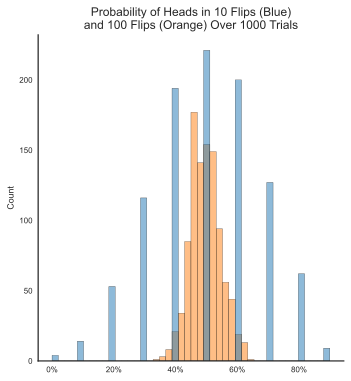

In [11]:
g = sns.displot([fair_flips_10_set, fair_flips_100_set], kind='hist', legend=False)
g.ax.set_title('Probability of Heads in 10 Flips (Blue)\nand 100 Flips (Orange) Over 1000 Trials', size=12)
g.ax.xaxis.set_major_formatter(PercentFormatter(1))

To conclude with the modeling discussion, we create a model to give us measurable estimate of uncertainty in both our actual data and differences between groups.  This is the utility of statistics.

<br><br>
## Modeling our HEDIS Compliance

Returning to our HEDIS compliance, we can model our data in the same way we did the coin flips: starting with the HEDIS rates, and knowing the number of members we have in each group, we sample from Bernoullis (one with a 70% compliance, and the other with a 40% compliance), just like coin flips.  Here, though, each element in the arrays we create is a member, and whether or not they were compliant.  

In [12]:
group_a_n = 100
group_a_rate = 0.7

group_b_n = 100
group_b_rate = 0.4

group_a_members = bernoulli.rvs(p=group_a_rate, size=group_a_n)
group_b_members = bernoulli.rvs(p=group_b_rate, size=group_b_n)

group_a_members

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1])

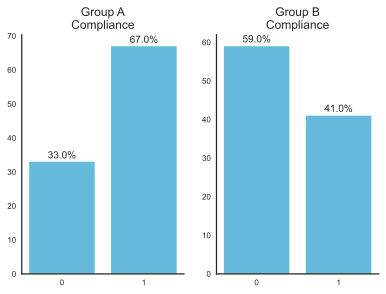

In [13]:

plot_hist([group_a_members, group_b_members], title=['Group A\nCompliance','Group B\nCompliance'], label='percent')


We'll get something a _little_ different each time we run this, just like with the coin flips.  Let's do the "repeated draws" approach for this, as well, to see how much this might range.

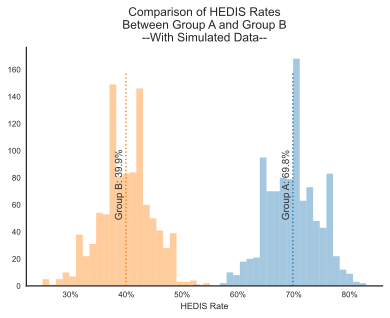

In [14]:
group_a_array = np.zeros(1000)
group_b_array = np.zeros(1000)

for i in range(1000):
    group_a_members = bernoulli.rvs(p=group_a_rate, size=group_a_n)
    group_b_members = bernoulli.rvs(p=group_b_rate, size=group_b_n)

    group_a_compliance_rate = np.mean(group_a_members)
    group_b_compliance_rate = np.mean(group_b_members)
    
    group_a_array[i] = group_a_compliance_rate
    group_b_array[i] = group_b_compliance_rate
    

fig, ax = plt.subplots(1,1)
pal=sns.color_palette(palette=None)

g = sns.distplot(group_a_array, ax=ax, kde=False)
g.axvline(x=np.mean(group_a_array), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('Group A: {:.1%}'.format(np.mean(group_a_array)), 
           xy=(np.mean(group_a_array)-0.02, 50), rotation=90, color='#333333')

g = sns.distplot(group_b_array, ax=ax, kde=False)
g.axvline(x=np.mean(group_b_array), ymin=0, ymax=0.9, linestyle=':', color=pal[1])
g.annotate('Group B: {:.1%}'.format(np.mean(group_b_array)), 
           xy=(np.mean(group_b_array)-0.02, 50), rotation=90, color='#333333')


g.set_title('Comparison of HEDIS Rates\nBetween Group A and Group B\n--With Simulated Data--', size=12)
g.set_xlabel('HEDIS Rate')
g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();


### Bayesian modeling with only the actual datasets

What we've done thus far is model what the HEDIS rate for Group A _could_ reasonably range around, if we had the luxury of getting the provider's data many, many times.  In practice, this is really unlikely--how would we have lots of measures of this doc's particular HEDIS rates?  Would they be for the same physician group over multiple years?  Are they for individual doctors' patients within a larger physician practice?  We really need to derive this estimate's likelihood distribution using only the data we have: one sample, as-is.  

Using Bayesian inference, we can get this distribution having only the one data sample.  

In [15]:
with pm.Model() as group_a_model:
    p_prior = pm.Uniform('p_prior', 0, 1)
    
    likelihood = pm.Bernoulli('likelihood', p=p_prior, observed=group_a_members)
    
    trace_a = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_prior]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


The _trace_ contains the information from the estimation process.  This is where we get our data for the estimates we've created here.  The estimate of interest in this model is the probability of HEDIS compliance, given the observed data.  

Those folks familiar with statistical processes may wonder why we care about the prior for the final probability estimate, when we've specified it's a Uniform(0,1), which means we're assuming the HEDIS rate could be anything from 0% to 100%, with all these probabilities equally likely....  The reason is that a Bayesian process is iterative, _updating the prior_ as new information is learned.  In our case here, we started with a (naive) assumption that the true HEDIS rate for Group A could be anywhere in the 0%-100% range, which is given in the specification of the prior in the model: <code>p_prior = pm.Uniform('p_prior', 0, 1)</code>.  That p_prior variable was updated, however, as the sampling process was run.  Let's take a look at where p_prior landed:

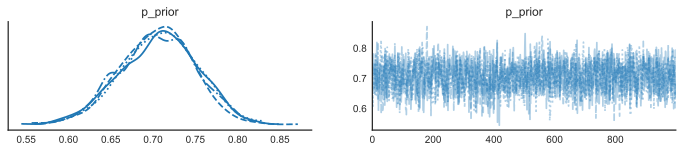

In [16]:
az.plot_trace(trace_a)
sns.despine();

This "traceplot" returns a row for every sampled (aka "free", aka "non-deterministic") parameter in the model, along with two charts per row.  The left-hand plot is an estimate for the entire distribution of the parameter, where each line is a separate "chain" (we're using a form of sampling called Markov Chain Monte Carlo--actually Hamiltonian Monte Carlo), and the sampler will create multiple chains in parallel--to the extent your computer hardware will support it.  The right-hand chart shows how the parameter ranged during sampling.  This traceplot is used for diagnostic purposes, to see if the sampler was able to do a good job at estimation for the parameters: in the left-hand chart, the chains should overlay each other pretty closely, and  the right-hand chart should look something like a "fuzzy caterpillar" (rather than having a distinct horizontal line anywhere).

Some more information is available in the "Further Reading" section at the bottom (Jason Preszler 2019).  

We can access the data in the trace by indexing it by variable name: this works differently, depending on whether the trace is an "inference_data" object.  PyMC3 moved from their own native trace data structure to this new inference_data structure (it comes from the _Arviz_ library), which has some more functionality.  In an inference_data trace, our "p\_prior" variable is stored within a "posterior" substructure.

In [17]:
trace_a

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

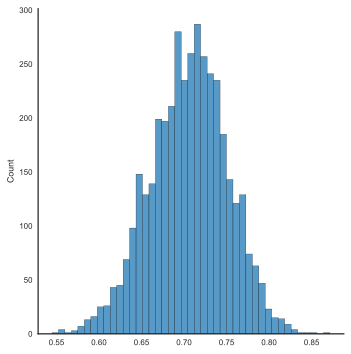

In [18]:
p_prior_a = np.ndarray.flatten(trace_a.posterior['p_prior'].values)
sns.displot(p_prior_a);

We have a good deal more fidelity in this histogram than we had in prior plots.  This is because our sample is much larger: we have results from four chains of size 1000, which are stored in an array containing 4000 numbers overall.  In the inference_data trace, these four chains are separate sub-arrays with multiple dimensions, so by calling <code>ndarray.flatten</code> from numpy, we turn that into just one long array.  

Most importantly, the size of the trace sample does not affect the _spread_ of the estimate.  Like the coin flips example, this is like the total number of _trials_.  The spread of the estimate is influenced by the size of our data (100 members).

In [19]:
print('Array contains {} entries, with a dimension of {}'.format(len(p_prior_a), 
                                                                 np.ndim(p_prior_a)
                                                                )
     )

Array contains 4000 entries, with a dimension of 1


One more thing we can do is show the model as a _graph_, to give some visual understanding of how the model is specified.  This one is pretty simple: <code>p_prior</code>, which starts off as Uniform (equal likelihood across its range, which for this model is 0 to 1) is used in the Bayesian estimation to describe <code>likelihood</code> which is a variable that contains real data (consisting of 100 observations).

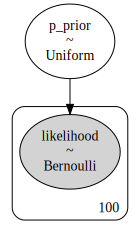

In [20]:
pm.model_to_graphviz(group_a_model)

<br>
We have another estimate to make, and we can repeat the process with Group B:

In [21]:
with pm.Model() as group_b_model:
    p_prior = pm.Uniform('p_prior', 0, 1)
    
    likelihood = pm.Bernoulli('likelihood', p=p_prior, observed=group_b_members)
    
    trace_b = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_prior]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


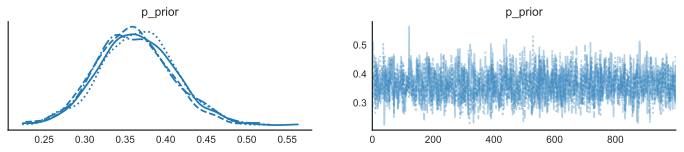

In [22]:
az.plot_trace(trace_b)
sns.despine();

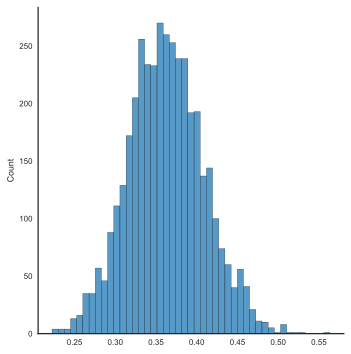

In [23]:
p_prior_b = np.ndarray.flatten(trace_b.posterior['p_prior'].values)
sns.displot(p_prior_b);

These estimates will make more sense relative to each other if they're plotted on the same chart:

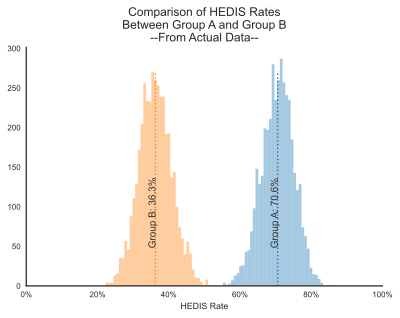

In [24]:
fig, ax = plt.subplots(1,1)
pal=sns.color_palette(palette=None)

g = sns.distplot(p_prior_a, ax=ax, kde=False)
g.axes.set_xlim(0,1)
g.axvline(x=np.mean(p_prior_a), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('Group A: {:.1%}'.format(np.mean(p_prior_a)), 
           xy=(np.mean(p_prior_a)-0.02, 50), rotation=90, color='#333333')

g = sns.distplot(p_prior_b, ax=ax, kde=False)
g.axvline(x=np.mean(p_prior_b), ymin=0, ymax=0.9, linestyle=':', color=pal[1])
g.annotate('Group B: {:.1%}'.format(np.mean(p_prior_b)), 
           xy=(np.mean(p_prior_b)-0.02, 50), rotation=90, color='#333333')

g.set_title('Comparison of HEDIS Rates\nBetween Group A and Group B\n--From Actual Data--', size=12)
g.set_xlabel('HEDIS Rate')
g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();

<br><br>
### Creating a single model that also creates an estimate of the difference between groups  

Rather than estimating these rate distributions with two models, we can do it one, and while we're at it, create a distinct estimate for the difference between the two groups.  This difference is really what we're after, ultimately: a measure of how like or unlike these two groups' rates are, accounting for uncertainty.

In [25]:
with pm.Model() as group_combined_model:
    p_prior_a = pm.Uniform('p_prior_a', 0, 1)
    p_prior_b = pm.Uniform('p_prior_b', 0, 1)
    
    p_difference = pm.Deterministic('p_difference', p_prior_a - p_prior_b)
    
    likelihood_a = pm.Bernoulli('likelihood_a', p=p_prior_a, observed=group_a_members)
    likelihood_b = pm.Bernoulli('likelihood_b', p=p_prior_b, observed=group_b_members)
    
    trace_combined = pm.sample(1000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_prior_b, p_prior_a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


The model design is a little different for this one: we have two parameters, <code>p_prior_a</code> and <code>p_prior_b</code>, which are used to describe the real observations <code>likelihood_a</code> and <code>likelihood_b</code>, respectively.  This "respectively" separation is important--p_prior_a isn't influenced the the likelihood_b data, and p_prior_b isn't influenced by the likelihood_a data.  Both are used, however, in calculating the data in <code>p_difference</code>.  Note that p_difference has a special specification: Deterministic.  This means the variable isn't a "free" parameter--it is not part of the estimation process, but rather is explicitly calculated from p_prior_a and p_prior_b the whole time _they_ are estimated.

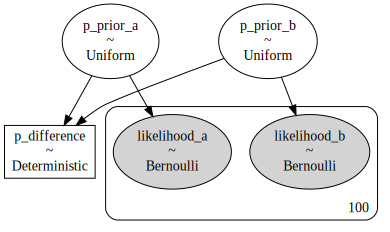

In [26]:
pm.model_to_graphviz(group_combined_model)

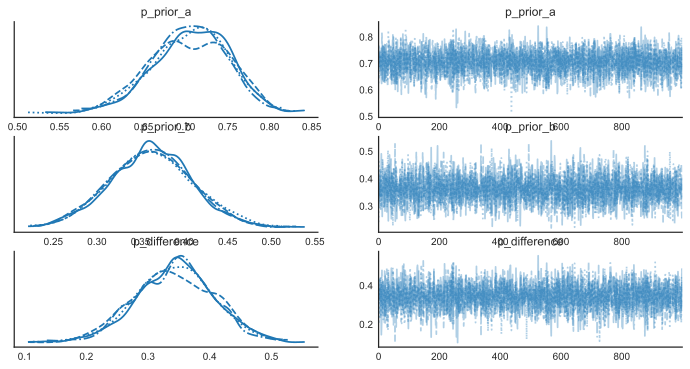

In [27]:
az.plot_trace(trace_combined)
sns.despine();

<br><br>
### Making a credible interval / region of practical equivalence

One more thing that's often done in statistics is to create some comfortable cutoff in our uncertainty measure.  Technically, the tails of the probability distribution for our difference go off to infinity in both directions (positive and negative).  There is some chance, however remote, that we can have outliers.  By convention, one thing to do is to create an interval "centered" at the maximum likelihood estimate (MLE) that contains some percentage of the mass of the distribution.  In the Bayesian paradigm, this is called a __credible interval__ or a __region of practical equivalence__.  Important to note: this is not the same thing as a confidence interval, despite the similar name.

Check out the "Further Reading" section at the bottom for more on the difference (Makowski:bayestestR & _What's the difference_ 2010).

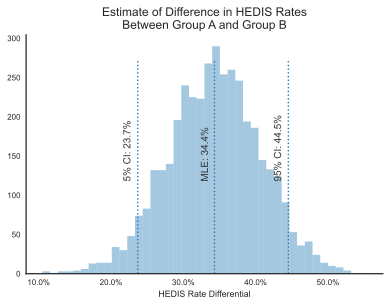

In [28]:
diff_data = np.ndarray.flatten(trace_combined.posterior['p_difference'].values)
# To get our 95% interval, we'll use quantiles (at 5% for the low end and 95% for the high end)
estimate_cilo = np.quantile(diff_data, 0.05)
estimate_cihi = np.quantile(diff_data, 0.95)

fig, ax = plt.subplots(1,1)
g = sns.distplot(diff_data, ax=ax, kde=False)
g.set_title('Estimate of Difference in HEDIS Rates\nBetween Group A and Group B', size=12)
g.set_xlabel('HEDIS Rate Differential')
g.axvline(x=np.mean(diff_data), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('MLE: {:.1%}'.format(np.median(diff_data)), 
           xy=(np.median(diff_data)-0.02, 120), rotation=90, color='#333333')


g.axvline(x=estimate_cilo, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('5% CI: {:.1%}'.format(estimate_cilo), 
           xy=(estimate_cilo-0.02, 120), rotation=90, color='#333333')

g.axvline(x=estimate_cihi, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('95% CI: {:.1%}'.format(estimate_cihi), 
           xy=(estimate_cihi-0.02, 120), rotation=90, color='#333333')

g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();


We can report this as _MLE_ with 95% interval (_CI low_, _CI high_), or as _MLE_ ± half the interval.  I would caution here, if using the latter, to make sure that the distribution of the estimate of the difference is reasonbly symmetrical.

In [29]:
def report_estimate(data, ci_mass=0.95, percent=True):
    estimate_mle  = np.median(data)   # MLE can also be the mean, but since we're using quantiles, median is consistent.
    estimate_cilo = np.quantile(data, 1-ci_mass)
    estimate_cihi = np.quantile(data, ci_mass)
    
    lhs_range = estimate_mle - estimate_cilo # lhs = lefthand side
    rhs_range = estimate_cihi - estimate_mle # rhs = righthand side
    
    # Symmetric (lhs and rhs reasonably similar)
    if (rhs_range - lhs_range) / lhs_range < 0.05:  # reasonably similar: we're using 5% (relative to each other)
        half_range = (rhs_range + lhs_range)/2.0
        
        # Reporting as a percent
        if percent==True:
            return '{}% ±{}%'.format(np.round(estimate_mle*100,1),
                                     np.round(half_range*100,1)
                                    )
        # Reporting as raw number
        else:
            return '{} ±{}'.format(np.round(estimate_mle,1),
                                     np.round(half_range,1)
                                    )
        
    # Asymmetric (lhs and rhs reasonably dissimilar)
    else:
        # Reporting as a percent
        if percent==True:
            return '{}%, {}% CI: ({}%, {}%)'.format(np.round(estimate_mle*100,1), 
                                                ci_mass*100,
                                                np.round(estimate_cilo*100,1), 
                                                np.round(estimate_cihi*100,1)
                                               )
        # Reporting as raw number
        else:
            return '{}, {} CI: ({}, {})'.format(np.round(estimate_mle,1), 
                                                ci_mass*100,
                                                np.round(estimate_cilo,1), 
                                                np.round(estimate_cihi,1)
                                               )
    
    

In [30]:
# We'll print the output as markdown
from IPython.display import Markdown as md

diff_data = np.ndarray.flatten(trace_combined.posterior['p_difference'].values)

md('Estimate of difference between Group A and Group B: {}'.format(report_estimate(diff_data)))

Estimate of difference between Group A and Group B: 34.4% ±10.4%

<br>
Another thing done in practice: starting with meaningful priors.  Our starting point was a Uniform(0,1), but we may have more useful information to start with, such as prior-year average rates.  If you have information like that, use it!  

Also commonly done in practice is to use a _hierarchical_ design.  Other names for this are multilevel modeling and mixed modeling.  The core idea is that our prior, rather than having its value specified directly at the start, is itself interacting with a higher-level prior.  This may seem unnecessary, but there are two results of the hierarchical design that make it useful in practice.

__Overfitting__  
First, all our groups' priors are linked to that higher-level prior--consequently, that single higher-level prior is shaped by the updating that is happening in the lower-level group priors, and it starts to become an average of those lower-level priors.  Because the higher-level prior and the lower-level priors influence each other, this reduces the risk that the lower-level priors will overfit to the data (that is, making the model look so much like the data we have that it can't adequately describe our uncertainty in it).  In other words, the estimate of the Group A prior becomes slightly influenced by an average of both the performance of itself and Group B (the "average" performance which comes from the higher-level prior).  The way Bayesian updating works, that influence from the higher-level prior is smaller and smaller as the data for the group (here, the number of members) is larger and larger.  Conversely, this also suggests that the influence of the higher-level prior on the lower-level prior is _larger_ when the data for the lower-level prior is _smaller_, and brings us to the second benefit.

__Shrinkage__  
In our example, both Group A and Group B have exactly 100 members.  Our example is entirely contrived, but in practice, some researchers might do this on purpose, sampling from groups such that the group sizes for study are equal.  Historically, this was done to make the math easier (back when statistics was largely frequentist and done by hand), because the frequentist statistical methods include different formulas and algorithms, depending on whether groups under study are differently-sized or differently-varying.  By using a hierarchical model, it's unimportant if groups have unequal sizes, or if some of the groups are very, very small.  The priors for groups with very little data will be influenced more strongly by the higher-level prior.  Practically speaking, that higher-level prior is essentially a "pooled" estimate from all the groups, and if there are individual groups with little data, their estimates will look a bit more like that pooled estimate.  It's like a "regression to the mean" for parameter estimates (instead of data); and frequentists employ this idea, too, in mixed model "shrinkage estimators".  Because of the way Bayesian updating works--that the priors at different levels influence each other during parameter estimate updating--we get the shrinkage estimation with no additional work on our part.  

More information on is in the "Further Reading" section (G. David Carson 2015, and John Kruschke 2015).


In [31]:
with pm.Model() as group_combined_hierarchical_model:
    p_prior_pooled = pm.Uniform('p_prior_pooled', 0, 1)
    p_prior_sd = pm.Beta('p_prior_sd', mu=0.1, sigma=0.01)
    
    p_prior_a = pm.Beta('p_prior_a', mu=p_prior_pooled, sd=p_prior_sd)
    p_prior_b = pm.Beta('p_prior_b', mu=p_prior_pooled, sd=p_prior_sd)
    
    p_difference = pm.Deterministic('p_difference', p_prior_a - p_prior_b)
    
    likelihood_a = pm.Bernoulli('likelihood_a', p=p_prior_a, observed=group_a_members)
    likelihood_b = pm.Bernoulli('likelihood_b', p=p_prior_b, observed=group_b_members)
    
    trace_hierarchical = pm.sample(1000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_prior_b, p_prior_a, p_prior_sd, p_prior_pooled]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 66 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Here's a visualization of our hierarchical design.  The hierarchy is such: at the top level, we have the "pooled" prior, <code>p_prior_pooled</code>, and the group-level priors at the bottom (<code>p\_prior\_a</code> and <code>p\_prior\_b</code>).  In this graphic, the _actual_ bottom row consists of the data and the deterministic (non-free-to-vary parameter) code>p\_difference</code>, but we're talking about the free parameters in terms of the hierarchy (the first two rows).  

We changed the kind of distribution for the group priors from Uniform to Beta.  A Uniform prior is a "non-informed" prior, which is to say, we're not defining it at the start with anything we already know or suspect (like prior-year average performance).  Instead, by using a Uniform(0,1) we're saying "any value is equally likely, just keep it between zero and one", and we've kept that definition for the top-level pooled prior.  However, the lower-level group priors _are_ informed, which means we use a distribution that 1) takes some meaningful parameter besides an upper-bound/lower-bound range (like probability), but 2) is also still just constrained to the range between 0 and 1.  

We have a few choices out-of-the-box (in PyMC3) for distribution that are constrained to the range (0,1): Beta, Kumaraswamy, and LogitNormal.  Here, the Beta was chosen to keep the model simple, as the Beta takes two parameters: a mean and a standard deviation.  The standard deviation is modeled in the top level as a Beta, as well, since the spread of p\_prior\_pooled has to be constrained to the (0,1) range, as well.

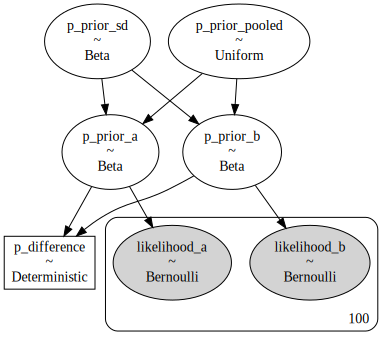

In [32]:
pm.model_to_graphviz(group_combined_hierarchical_model)

C:\Users\dusti\AppData\Local\Temp\ipykernel_40836\1114130624.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_hierarchical);
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


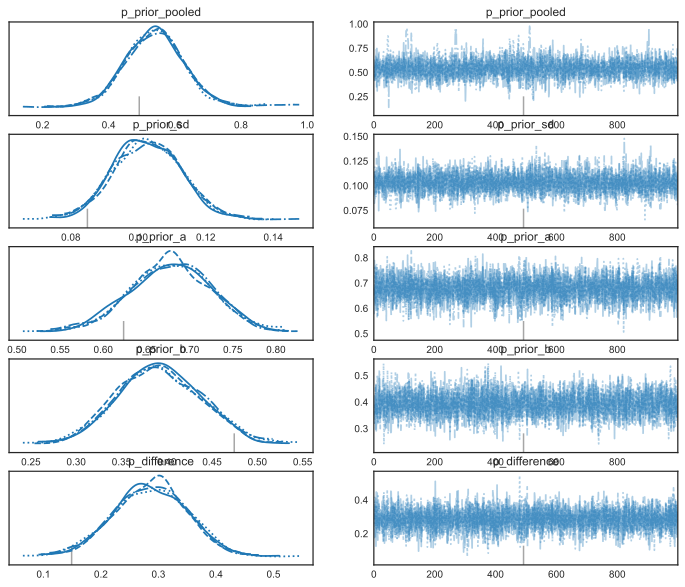

In [33]:
pm.traceplot(trace_hierarchical);

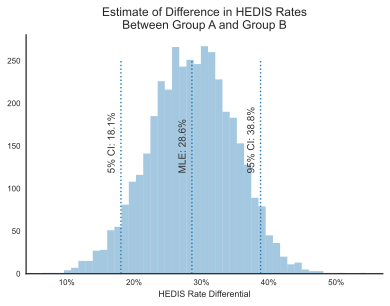

In [34]:
diff_data = trace_hierarchical['p_difference']

# To get our 95% interval, we'll use quantiles (at 5% for the low end and 95% for the high end)
df_estimate_cilo = np.quantile(diff_data, 0.05)
df_estimate_cihi = np.quantile(diff_data, 0.95)

fig, ax = plt.subplots(1,1)
g = sns.distplot(diff_data, ax=ax, kde=False)
g.set_title('Estimate of Difference in HEDIS Rates\nBetween Group A and Group B', size=12)
g.set_xlabel('HEDIS Rate Differential')
g.axvline(x=np.mean(diff_data), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('MLE: {:.1%}'.format(np.mean(diff_data)), 
           xy=(np.mean(diff_data)-0.02, 120), rotation=90, color='#333333')


g.axvline(x=df_estimate_cilo, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('5% CI: {:.1%}'.format(df_estimate_cilo), 
           xy=(df_estimate_cilo-0.02, 120), rotation=90, color='#333333')

g.axvline(x=df_estimate_cihi, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('95% CI: {:.1%}'.format(df_estimate_cihi), 
           xy=(df_estimate_cihi-0.02, 120), rotation=90, color='#333333')

g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();

In [35]:
diff_data = trace_hierarchical['p_difference']
md('Estimate of difference between Group A and Group B: {}'.format(report_estimate(diff_data)))

Estimate of difference between Group A and Group B: 28.8% ±10.4%

Statistically speaking, why do we really care about this interval, if we know what the most likely difference is?  Why not just use the maximum likelihood estimate (MLE)?  One thing we can do in the Bayesian paradigm that _cannot_ be done in the frequentist one is say, based on this estimation we just did: we are 95% sure the difference in HEDIS compliance between Group A and Group B is between 13% and 30% (the specificity of the data you got will depend on your run).  And here's the important thing: if that interval contains zero, then we're not sure there really is a difference between the two groups!  Another way to say that (assuming 0 was within our interval): in what is most plausible (the interval) for the difference between the two groups, it may be there is actually no difference.

Also, the 95% interval is merely a convention.  Some use other intervals, like 90% or 99%, and there are pros and cons to any of these selections.  John Kruschke, in his 2014 book _Doing Bayesian data analysis: A tutorial with R, JAGS, and Stan_, suggested 89%, which others, like Richard McElreath take some jabs at (more in "Further Reading" (D. Makowski: Credible Intervals)) .

## Data size matters

We can do a similar run with a similar model, but take a look at how the size of the data makes a difference in our uncertainty for the difference between HEDIS rates.  In this run, we'll make the groups more similar, at only a 10% difference in HEDIS compliance, but make the group sizes smaller, with only 40 and 50 members, respectively.

In [36]:
group_a_rate = 0.6
group_b_rate = 0.7

group_a_n = 40
group_b_n = 50

group_a_members = bernoulli.rvs(p=group_a_rate, size=group_a_n)
group_b_members = bernoulli.rvs(p=group_b_rate, size=group_b_n)

In [37]:
with pm.Model() as group_combined_hierarchical_model:
    p_prior_pooled = pm.Uniform('p_prior_pooled', 0, 1)
    p_prior_sd = pm.Beta('p_prior_sd', mu=0.1, sigma=0.01)
    
    p_prior_a = pm.Beta('p_prior_a', mu=p_prior_pooled, sigma=p_prior_sd)
    p_prior_b = pm.Beta('p_prior_b', mu=p_prior_pooled, sigma=p_prior_sd)
    
    p_difference = pm.Deterministic('p_difference', p_prior_a - p_prior_b)
    
    likelihood_a = pm.Bernoulli('likelihood_a', p=p_prior_a, observed=group_a_members)
    likelihood_b = pm.Bernoulli('likelihood_b', p=p_prior_b, observed=group_b_members)
    
    trace_hierarchical = pm.sample(1000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_prior_b, p_prior_a, p_prior_sd, p_prior_pooled]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 65 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


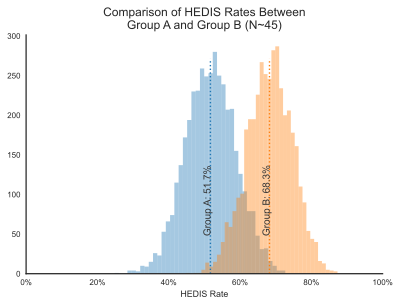

In [38]:
p_prior_a = trace_hierarchical['p_prior_a']
p_prior_b = trace_hierarchical['p_prior_b']

fig, ax = plt.subplots(1,1)
pal=sns.color_palette(palette=None)

g = sns.distplot(p_prior_a, ax=ax, kde=False)
g.axes.set_xlim(0,1)
g.axvline(x=np.mean(p_prior_a), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('Group A: {:.1%}'.format(np.mean(p_prior_a)), 
           xy=(np.mean(p_prior_a)-0.02, 50), rotation=90, color='#333333')

g = sns.distplot(p_prior_b, ax=ax, kde=False)
g.axvline(x=np.mean(p_prior_b), ymin=0, ymax=0.9, linestyle=':', color=pal[1])
g.annotate('Group B: {:.1%}'.format(np.mean(p_prior_b)), 
           xy=(np.mean(p_prior_b)-0.02, 50), rotation=90, color='#333333')

g.set_title('Comparison of HEDIS Rates Between\nGroup A and Group B (N~45)', size=12)
g.set_xlabel('HEDIS Rate')
g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();

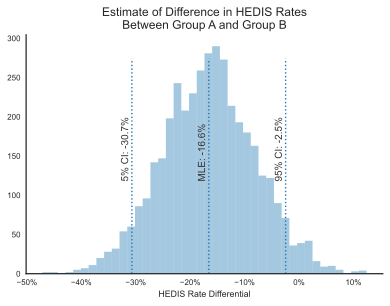

In [39]:
diff_data = trace_hierarchical['p_difference']

# To get our 95% interval, we'll use quantiles (at 5% for the low end and 95% for the high end)
df_estimate_cilo = np.quantile(diff_data, 0.05)
df_estimate_cihi = np.quantile(diff_data, 0.95)

fig, ax = plt.subplots(1,1)
g = sns.distplot(diff_data, ax=ax, kde=False)
g.set_title('Estimate of Difference in HEDIS Rates\nBetween Group A and Group B', size=12)
g.set_xlabel('HEDIS Rate Differential')
g.axvline(x=np.mean(diff_data), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('MLE: {:.1%}'.format(np.mean(diff_data)), 
           xy=(np.mean(diff_data)-0.02, 120), rotation=90, color='#333333')


g.axvline(x=df_estimate_cilo, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('5% CI: {:.1%}'.format(df_estimate_cilo), 
           xy=(df_estimate_cilo-0.02, 120), rotation=90, color='#333333')

g.axvline(x=df_estimate_cihi, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('95% CI: {:.1%}'.format(df_estimate_cihi), 
           xy=(df_estimate_cihi-0.02, 120), rotation=90, color='#333333')

g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();

Our interval contains zero--on your run, it may be reasonably close.  

Let's run the same thing again, but with one difference: the group sizes will now be 200 and 250, respectively.

In [40]:
group_a_rate = 0.6
group_b_rate = 0.7

group_a_n = 200
group_b_n = 250

group_a_members = bernoulli.rvs(p=group_a_rate, size=group_a_n)
group_b_members = bernoulli.rvs(p=group_b_rate, size=group_b_n)

In [41]:
with pm.Model() as group_combined_hierarchical_model:
    p_prior_pooled = pm.Uniform('p_prior_pooled', 0, 1)
    p_prior_sd = pm.Beta('p_prior_sd', mu=0.1, sigma=0.01)
    
    p_prior_a = pm.Beta('p_prior_a', mu=p_prior_pooled, sigma=p_prior_sd)
    p_prior_b = pm.Beta('p_prior_b', mu=p_prior_pooled, sigma=p_prior_sd)
    
    p_difference = pm.Deterministic('p_difference', p_prior_a - p_prior_b)
    
    likelihood_a = pm.Bernoulli('likelihood_a', p=p_prior_a, observed=group_a_members)
    likelihood_b = pm.Bernoulli('likelihood_b', p=p_prior_b, observed=group_b_members)
    
    trace_hierarchical = pm.sample(1000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_prior_b, p_prior_a, p_prior_sd, p_prior_pooled]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 75 seconds.


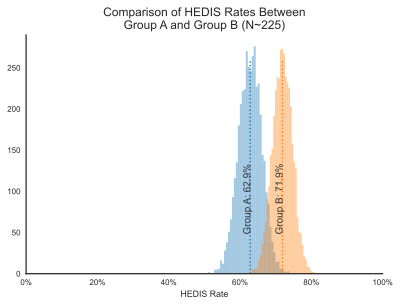

In [42]:
p_prior_a = trace_hierarchical['p_prior_a']
p_prior_b = trace_hierarchical['p_prior_b']

fig, ax = plt.subplots(1,1)
pal=sns.color_palette(palette=None)

g = sns.distplot(p_prior_a, ax=ax, kde=False)
g.axes.set_xlim(0,1)
g.axvline(x=np.mean(p_prior_a), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('Group A: {:.1%}'.format(np.mean(p_prior_a)), 
           xy=(np.mean(p_prior_a)-0.02, 50), rotation=90, color='#333333')

g = sns.distplot(p_prior_b, ax=ax, kde=False)
g.axvline(x=np.mean(p_prior_b), ymin=0, ymax=0.9, linestyle=':', color=pal[1])
g.annotate('Group B: {:.1%}'.format(np.mean(p_prior_b)), 
           xy=(np.mean(p_prior_b)-0.02, 50), rotation=90, color='#333333')

g.set_title('Comparison of HEDIS Rates Between\nGroup A and Group B (N~225)', size=12)
g.set_xlabel('HEDIS Rate')
g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();

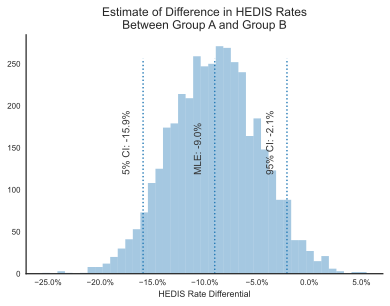

In [43]:
diff_data = trace_hierarchical['p_difference']

# To get our 95% interval, we'll use quantiles (at 5% for the low end and 95% for the high end)
df_estimate_cilo = np.quantile(diff_data, 0.05)
df_estimate_cihi = np.quantile(diff_data, 0.95)

fig, ax = plt.subplots(1,1)
g = sns.distplot(diff_data, ax=ax, kde=False)
g.set_title('Estimate of Difference in HEDIS Rates\nBetween Group A and Group B', size=12)
g.set_xlabel('HEDIS Rate Differential')
g.axvline(x=np.mean(diff_data), ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('MLE: {:.1%}'.format(np.mean(diff_data)), 
           xy=(np.mean(diff_data)-0.02, 120), rotation=90, color='#333333')


g.axvline(x=df_estimate_cilo, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('5% CI: {:.1%}'.format(df_estimate_cilo), 
           xy=(df_estimate_cilo-0.02, 120), rotation=90, color='#333333')

g.axvline(x=df_estimate_cihi, ymin=0, ymax=0.9, linestyle=':', color=pal[0])
g.annotate('95% CI: {:.1%}'.format(df_estimate_cihi), 
           xy=(df_estimate_cihi-0.02, 120), rotation=90, color='#333333')

g.xaxis.set_major_formatter(PercentFormatter(1))
sns.despine();

And now you should see that zero is _outside_ our credibility interval / region of practical equivalence: less of the mass of the two groups' rate estimates are shared/overlap.  Two factors are at work here in our simple two-group Beta/Bernoulli comparison: how far apart the group rates are, and how big the group sizes are.  

---

I challenge you to try the following as exercises:  

1. See what happens when the data show 100% compliance or 0% compliance in a simple (i.e., likelihood-and-one-prior model).  What are some ways to mitigate problems in a simple model?  

2. Create functions to generate group data and run Bayesian models.  Loop through different group sizes and differences.  Plot a relationship between size, rate difference, and whether the interval contains zero.  This is something like a _power analysis_ to know under what situations you're likely to detect a meaningful difference between groups.  

3. Generate comparisons for more than three groups (ideally with real data--use real group data and sizes), comparing each to mean overall performance to find those with significant above-average performance and those with significant below-average performance.  Create a visualization to segment the groups, perhaps with three-color separation (e.g., green:significant above, red: significant below, yellow: insignificant difference).  

4. With two or three years of HEDIS rate compliance at a member level (that is, knowing whether a member is compliant with a particular measure in particular year), create a model to show how likely a member is to be compliant in year 2 (or year 3), given their compliance in the previous year.  

---


# Further reading  

Seeing Theory, <a href="https://seeing-theory.brown.edu/bayesian-inference/index.html" target="_blank">_Chapter 5: Bayesian Inference_</a>.  Available at: seeing-theory.brown.edu/bayesian-inference/index.html, retrieved Feb. 2, 2022.


Jason Brownlee.  <a href="https://machinelearningmastery.com/markov-chain-monte-carlo-for-probability/" target="_blank">_A Gentle Introduction to Markov Chain Monte Carlo for Probability._</a> Available at: machinelearningmastery.com/markov-chain-monte-carlo-for-probability/, retrieved Feb. 2, 2022.  


Jason Preszler.  <a href="https://jpreszler.rbind.io/post/2019-09-28-bad-traceplots/" target="_blank">_When Traceplots Go Bad._</a>  Available at: jpreszler.rbind.io/post/2019-09-28-bad-traceplots/, retrieved Feb. 2, 2022.  


<a href="https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval" target="_blank">_What's the difference between a confidence interval and a credible interval?_</a>  StackExchange (Sep. 1, 2010).  Available at: stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval, retrieved Feb. 3, 2022.  


D. Makowski, M. S. Ben-Shachar, D. Lüdecke. <a href="https://cran.r-project.org/web/packages/bayestestR/vignettes/region_of_practical_equivalence.html" target="_blank">_bayestestR: Describing Effects and their Uncertainty, Existence and Significance within the Bayesian Framework._</a> Journal of Open Source Software, (2019) 4(40), 1541. doi:10.21105/joss.01541


D. Makowski, M. S. Ben-Shachar, D. Lüdecke. <a href="https://easystats.github.io/bayestestR/articles/credible_interval.html" target="_blank">_Credible Intervals._</a> R vignette available at: easystats.github.io/bayestestR/articles/credible_interval.html, retrieved Feb. 6, 2022.


Arthur Charpentier. <a href="https://freakonometrics.hypotheses.org/18117" target="_blank">_Confidence vs. Credibility Intervals_</a>. Available at freakonometrics.hypotheses.org/18117, retrieved Feb. 3, 2022.

G. David Carson.  _Hierarchical Linear Modeling: Guide and Applications,_ Sage Research Methods (2014). <a href="https://www.sagepub.com/sites/default/files/upm-binaries/47528_ch_1.pdf" target="_blank">Chapter 1, pp. 3-24.</a> doi:dx.doi.org/10.4135/9781483384450.n1


John Kruschke.  <a href="http://doingbayesiandataanalysis.blogspot.com/2015/04/sex-death-and-unbalanced-designs-done.html" target="_blank">_Sex, death, and unbalanced designs (done Bayesian)_</a>, from Doing Bayesian Data Analysis (Apr. 7, 2015), retrieved Feb. 6, 2022.

